In [ ]:
!unzip  fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# Transform: Convert to tensor and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

# Split training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 253kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.70MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.8MB/s]


In [ ]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

ann_model = ANN_Model()


In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = CNN_Model()


In [ ]:
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
import numpy as np

def train_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    return model

def evaluate(model, loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm


In [ ]:
print("Training ANN model...")
ann_trained = train_model(ann_model, train_loader, val_loader, epochs=5)
ann_acc, ann_cm = evaluate(ann_trained, test_loader)

print("Training CNN model...")
cnn_trained = train_model(cnn_model, train_loader, val_loader, epochs=5)
cnn_acc, cnn_cm = evaluate(cnn_trained, test_loader)

print(f"ANN Accuracy: {ann_acc:.2f}%")
print(f"CNN Accuracy: {cnn_acc:.2f}%")


Training ANN model...
Epoch 1, Loss: 0.5107
Epoch 2, Loss: 0.3814
Epoch 3, Loss: 0.3387
Epoch 4, Loss: 0.3145
Epoch 5, Loss: 0.2915
Training CNN model...
Epoch 1, Loss: 0.4660
Epoch 2, Loss: 0.2994
Epoch 3, Loss: 0.2455
Epoch 4, Loss: 0.2135
Epoch 5, Loss: 0.1856
ANN Accuracy: 86.29%
CNN Accuracy: 91.31%


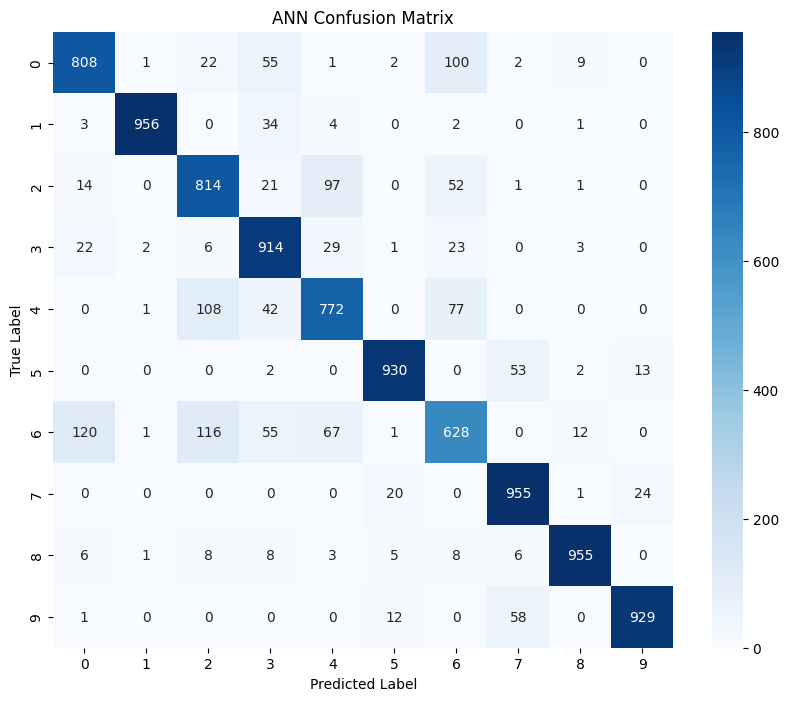

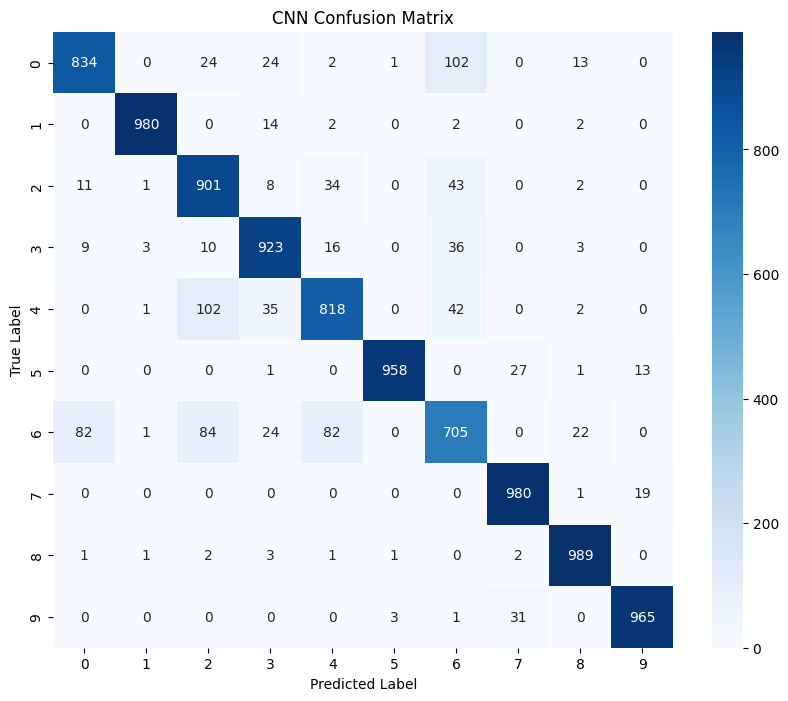

Analysis:
- ANN performed with accuracy: 86.61%
- CNN performed with accuracy: 90.53%
CNN shows better handling of spatial information, especially for similar classes like shirts vs. coats.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix for ANN
plt.figure(figsize=(10,8))
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues')
plt.title("ANN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot confusion matrix for CNN
plt.figure(figsize=(10,8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Describe observations
print("Analysis:")
print(f"- ANN performed with accuracy: {ann_acc:.2f}%")
print(f"- CNN performed with accuracy: {cnn_acc:.2f}%")
print("CNN shows better handling of spatial information, especially for similar classes like shirts vs. coats.")


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# Data augmentation transforms for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),      # Random horizontal flip
    transforms.RandomRotation(10),          # Random rotation ±10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Validation and test transforms (no augmentation, just normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets with transforms
full_train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=test_transform)

# Split training into train and validation sets (80/20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# For validation dataset, override transform to no augmentation, only normalization
val_dataset.dataset.transform = test_transform

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.dropout1 = nn.Dropout(0.3)  # Dropout added after first layer
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)  # Dropout added after second layer
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

ann_model = ANN_Model()


In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)  # Dropout before fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = CNN_Model()


In [ ]:
from torch.optim import Adam
from sklearn.metrics import confusion_matrix

def train_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_acc:.2f}%")

    return model

def evaluate(model, loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm


In [ ]:
print("Training ANN with Dropout and Augmentation...")
ann_trained = train_model(ann_model, train_loader, val_loader, epochs=5)

print("Training CNN with Dropout and Augmentation...")
cnn_trained = train_model(cnn_model, train_loader, val_loader, epochs=5)

ann_acc, ann_cm = evaluate(ann_trained, test_loader)
cnn_acc, cnn_cm = evaluate(cnn_trained, test_loader)

print(f"ANN Test Accuracy: {ann_acc:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")


Training ANN with Dropout and Augmentation...
Epoch 1, Loss: 0.3617, Validation Accuracy: 87.69%
Epoch 2, Loss: 0.3441, Validation Accuracy: 87.74%
Epoch 3, Loss: 0.3395, Validation Accuracy: 88.66%
Epoch 4, Loss: 0.3297, Validation Accuracy: 88.45%
Epoch 5, Loss: 0.3241, Validation Accuracy: 88.47%
Training CNN with Dropout and Augmentation...
Epoch 1, Loss: 0.2157, Validation Accuracy: 92.12%
Epoch 2, Loss: 0.1975, Validation Accuracy: 92.16%
Epoch 3, Loss: 0.1803, Validation Accuracy: 92.17%
Epoch 4, Loss: 0.1683, Validation Accuracy: 92.17%
Epoch 5, Loss: 0.1546, Validation Accuracy: 92.33%
ANN Test Accuracy: 87.45%
CNN Test Accuracy: 92.24%


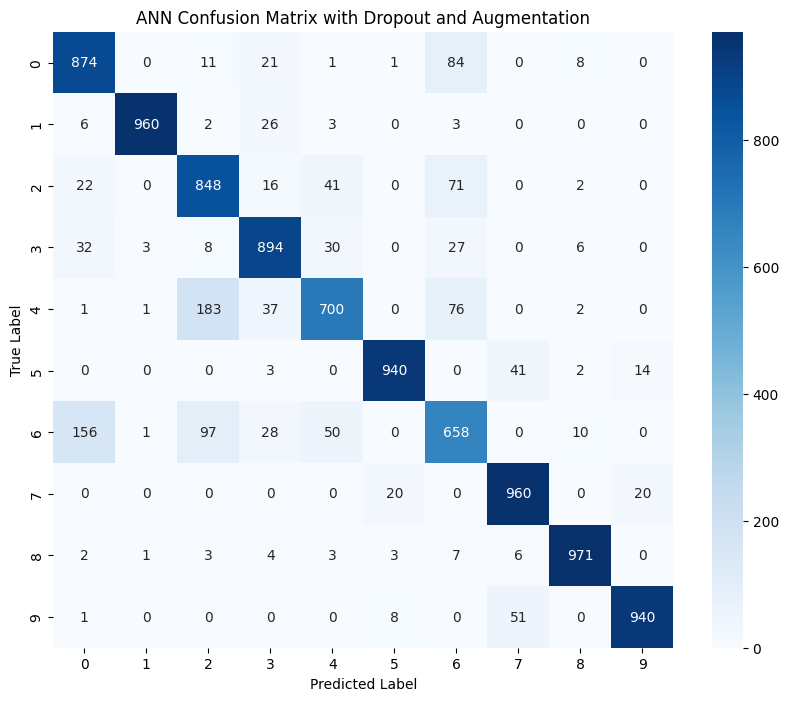

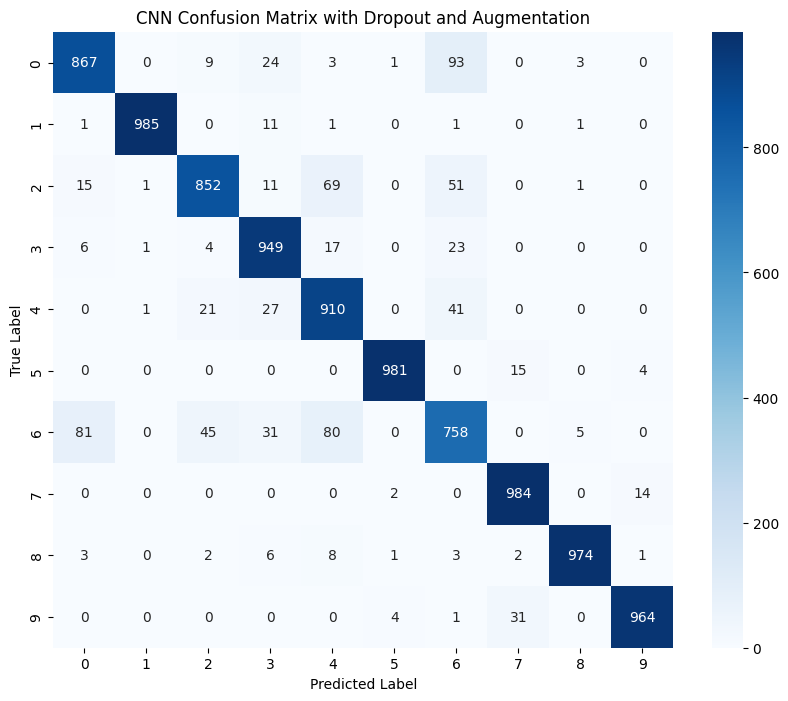

Analysis after adding Dropout and Data Augmentation:
- ANN Test Accuracy: 87.45%
- CNN Test Accuracy: 92.24%
Both models show improved performance with dropout and data augmentation. The CNN model still outperforms the ANN model, which is expected due to its ability to capture spatial features in images.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix for ANN with Dropout and Augmentation
plt.figure(figsize=(10,8))
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues')
plt.title("ANN Confusion Matrix with Dropout and Augmentation")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot confusion matrix for CNN with Dropout and Augmentation
plt.figure(figsize=(10,8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix with Dropout and Augmentation")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Describe observations
print("Analysis after adding Dropout and Data Augmentation:")
print(f"- ANN Test Accuracy: {ann_acc:.2f}%")
print(f"- CNN Test Accuracy: {cnn_acc:.2f}%")
print("Both models show improved performance with dropout and data augmentation. The CNN model still outperforms the ANN model, which is expected due to its ability to capture spatial features in images.")

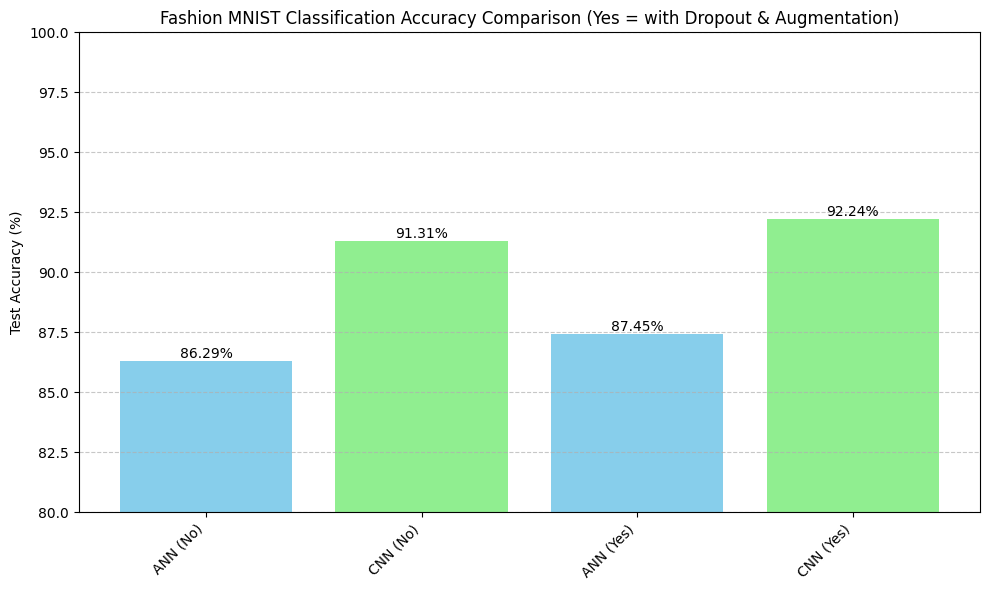

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data provided by the user
data = {
    'AI Model': ['ANN', 'CNN', 'ANN', 'CNN'],
    'Dropout & Augmentation': ['No', 'No', 'Yes', 'Yes'],
    'Test Accuracy': [86.29, 91.31, 87.45, 92.24]
}

df = pd.DataFrame(data)

# Create labels for the bars
labels = [f"{row['AI Model']} ({row['Dropout & Augmentation']})" for index, row in df.iterrows()]
acc_values = df['Test Accuracy'].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, acc_values, color=['skyblue', 'lightgreen', 'skyblue', 'lightgreen'])

plt.ylabel('Test Accuracy (%)')
plt.title('Fashion MNIST Classification Accuracy Comparison (Yes = with Dropout & Augmentation)')
plt.ylim(80, 100) # Set y-axis limits to focus on the range of accuracies
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()